### introduction

Here we will go through application of the Zhou partitioning algorithm to eddy covariance data. The script is designed to run on [FLUXNET2015](https://fluxnet.fluxdata.org/data/fluxnet2015-dataset/) .csv files directly, which ensures consistent variable names, processing and units. The tutorial will use data from the [Hyytiala forest](http://sites.fluxdata.org/FI-Hyy/) in Finland, but can be applied to any FLUXNET2015 dataset.

Some experience in Python will make things easy, but I will try to explain the process step by step so as to be accessible to all backgrounds.

### first things first

The firs step is to import all needed packages:

In [15]:
import xarray as xr # labelled multi-dimensional arrays that are compatable with netcdf formats
import numpy as np # numerical python for working with basic n-dimensional array
import warnings # standard library for suppressing warnings

# This secion facilitates easy plotting using xarray/pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import matplotlib.pyplot as pl

# These two packages are imported from local scripts in the repository
from preprocess import build_dataset # Converts the .csv to a labeled xarray Dataset
import bigleaf # Used for converting units (e.g. LE to ET)
import zhou

### loading the dataset

Here we used the build_datset function from the preprocess.py script, which chooses a subset of the variables from the FULLSET, as well as setting units, descriptive names, and site metadata into the file. Furthermore, only the years from 2008 to 2013 are seleced from the full timeseries. Comment out the second line if you would like to run the full datset.

In [16]:
ec = build_dataset("FLX_FI-Hyy_FLUXNET2015_FULLSET_HH_2008-2010_1-3.csv")

### check for an hourly file

**build_dataset** also check to see if the file is at hourly or half hourly resolution. We will be working with ET in units of mm per timestep, and therefor some calculations are slightly different.

In [17]:
if ec.agg_code == 'HH':
    hourlyMask      = xr.DataArray(np.ones(ec.time.shape).astype(bool),coords=[ec.time],dims=['time'])
    nStepsPerDay    = 48
else:
    hourlyMask      = np.ones(ec.time.shape).astype(bool)
    hourlyMask[::2] = False
    nStepsPerDay = 24

### unit conversions

Here we convert the estimated LE values to ET using the functions found in bigleaf.py.

In [18]:
ec['ET'] = (bigleaf.LE_to_ET(ec.LE, ec.TA)*60*60*(24/nStepsPerDay))
ec['ET'] = ec['ET'].assign_attrs(long_name = 'evapotranspiration',
                           units     = 'mm per timestep')

# fill missing NETRAD values with LE+H+G
ec['NETRAD'][np.isnan(ec['NETRAD'])] = ec['LE'][np.isnan(ec['NETRAD'])]+ec['H'][np.isnan(ec['NETRAD'])]+ec['G'][np.isnan(ec['NETRAD'])]

PET, _ = bigleaf.PET(ec.TA, ec.PA, ec.NETRAD,
                           G=ec.G, S=None, alpha=1.26,
                           missing_G_as_NA=False, missing_S_as_NA=False)
ec['PET'] = PET*60*60*(24/nStepsPerDay)

Storage flux S is not provided and set to 0.


### initial checks

Here we can do an initial precheck to see if the data looks reasonable. This one line will aggrigate the sub-daily flux to a daily sum. Note that if data is missing within a day, the entire day will return a NaN value (this can be changed by setting **skipna=True**). Feel free to test other variables by changing the variable name. Some good variables to check are GPP_NT and P. Daily means can also be calculated by changing **sum** to **mean**.

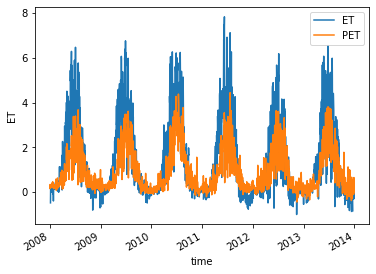

In [19]:
ec['PET'].resample(time='D').sum(skipna=False).plot(label='ET')
ec['ET'].resample(time='D').sum(skipna=False).plot(label='PET')
pl.legend()

### filter data

The first step in calculated transpiraiton from the Zhou method is to filter the data. Data filtration consists of four parts: quality, zero, season, and precip:

| filter  | reason               | implementation                              |
|:-------:|:--------------------:|:-------------------------------------------:|
| quality | only good quality    | [NEE_QC, LE_QC, TA_QC, VPD_QC] == 0 or 1    |
| zero    | only positive        | [ET, TA, VPD, NETRAD] > 0                   |
| season  | only in season       | GPP_day > 10% of 95th percentile of GPP_day |
| precip  | remove rainy periods | remove days with rain                       |
|         |                      | remove 1 day after rain if P_day > PET_day  |
|         |                      |remove 2 days after rain if P_day > 2*PET_day|

From these four filters we can get the uWUEa_Mask and uWUEp_Mask as:

uWUEa_Mask = zeroMask & qualityMask
uWUEp_Mask = zeroMask & qualityMask & precipMask & seasonMask

This has all been implement with the **zhouFlags** function in zhou.py, but it only works in an xarray dataset with the correct variable names. Note that the variant of GPP and be given (GPP_NT here).

In [6]:
uWUEa_Mask, uWUEp_Mask = zhou.zhouFlags(ec, nStepsPerDay, hourlyMask,
                                       GPPvariant='GPP_NT')

/home/jnelson/Documents/FluxnetTransp/matmet/zhou.py:38: RuntimeWarning: invalid value encountered in less
  QC[QC<0] = 3
/home/jnelson/Documents/FluxnetTransp/matmet/zhou.py:43: RuntimeWarning: invalid value encountered in greater
  qualityMask &= ds[var].values > -9000
/home/jnelson/Documents/FluxnetTransp/matmet/zhou.py:47: RuntimeWarning: invalid value encountered in greater
  zeroMask &= ds[var].values>0


### setting up the daily dataset

The Zhou method estimates transpiration at the daily timescale, so we need to make a new dataset at a daily resolution. We will start with making a new dataset from ET, and then make two blank dataarrays for our Zhou method T estimates. This process is much easier when using Xarray's **resample** funciton. We will set **skipna=False** so if days have missing ET values, the result for that day will be NaN rather than skipping the missing value and underestimating ET for that day.

In [7]:
ds_zhou = ec[['ET']].resample(time='D').sum(skipna=False)
ds_zhou['ET'] = ds_zhou['ET'].assign_attrs(
            long_name = 'evapotranspiration',
            units     = 'mm d-1')

ds_zhou['zhou_T'] = ds_zhou['ET']*np.nan
ds_zhou['zhou_T'] = ds_zhou['zhou_T'].assign_attrs(
            long_name = 'Zhou estimated transpiration with uWUEa calculate for each day, using GPP_NT',
            units     = 'mm d-1')

ds_zhou['zhou_T_8day'] = ds_zhou['ET']*np.nan
ds_zhou['zhou_T_8day'] = ds_zhou['zhou_T_8day'].assign_attrs(
            long_name = 'Zhou estimated transpiration with uWUEa calculate for an 8 day moving window (centered), using GPP_NT',
            units     = 'mm d-1')

### partitioning

Now we can run the actual partitioning. Compared to the TEA and Pérez-Priego methods, the Zhou method is very fast. Note that the GPP and VPD should be in gC m^-2 d^-1 and hPa, respectively. Also, the percentile used for calculating uWUEp can be specified as the rho parameter, here we use the 95th percentile which is recommending in Zhou et al 2016.

The output will be the estimated uWUEp as a single value, and the timeseries of transpiration both with uWUEa calculated for each day individually (**zhou_T**) and using an 8 day moving window (**zhou_T_8day**). Each year will be calculated separately, giving an unique uWUEp for the year. Here we have a simple for loop for each year, then the partitioning is done on the half-hourly data. The daily dataset (**ds_zhou**) is then updated with the estimates for each year.

In [8]:
ET  = ec.ET.values
GxV = (ec.GPP_NT*np.sqrt(ec.VPD)).values

for year in np.unique(ec['time.year']):
    yearMask = (ec['time.year']==year).values
    uWUEp, zhou_T, zhou_T_8day = zhou.zhou_part(ET[yearMask], GxV[yearMask],
                                          uWUEa_Mask[yearMask], uWUEp_Mask[yearMask],
                                          nStepsPerDay, hourlyMask[yearMask],
                                          rho = 95/100)
    ds_zhou['zhou_T'][ds_zhou['time.year']==year] = zhou_T
    ds_zhou['zhou_T_8day'][ds_zhou['time.year']==year] = zhou_T_8day
    print(year,'uWUEp = ',uWUEp)


2008 uWUEp =  734.0544055938731
2009 uWUEp =  809.1583502960211
2010 uWUEp =  741.3338013305668
2011 uWUEp =  878.9661698303232
2012 uWUEp =  861.7683174591073
2013 uWUEp =  854.7727275466932


### initial checks

Now we can do some diagnostic plots for each estimate. First just plots of daily T for both the daily and 8 daily estimates.

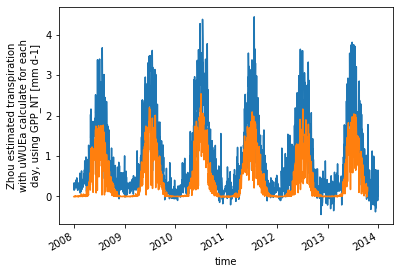

In [9]:
ds_zhou.ET.plot()
ds_zhou.zhou_T.plot()

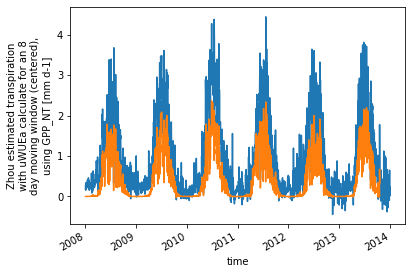

In [10]:
ds_zhou.ET.plot()
ds_zhou.zhou_T_8day.plot()

They both seem to agree. We can check directly by plotting them against each other.

(0, 3)

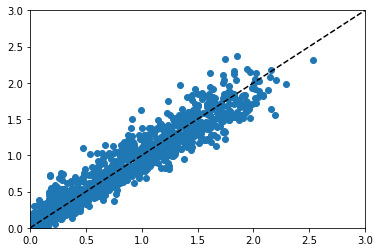

In [11]:
pl.scatter(ds_zhou.zhou_T,ds_zhou.zhou_T_8day)
pl.plot([0,3], [0,3], '--k')
pl.ylim(0,3)
pl.xlim(0,3)

Here we can look at the mean seasonal cycle of ET, zhou_T_8day, and zhou_E_8day.

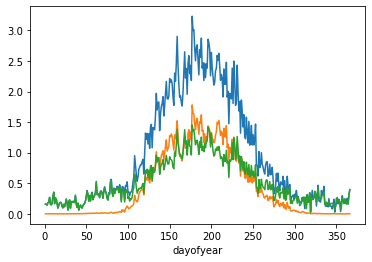

In [12]:
ds_zhou.ET.groupby('time.dayofyear').mean().plot()
ds_zhou.zhou_T_8day.groupby('time.dayofyear').mean().plot()
(ds_zhou.ET-ds_zhou.zhou_T_8day).groupby('time.dayofyear').mean().plot()

### data output

If you want to save your partitioned data, we can export directly to a netcdf format, which will preserve the current shape of the data.

In [13]:
ds_zhou.to_netcdf('FI-Hyy_Zhou_output.nc')

or back to a .csv file:

In [14]:
ds_zhou.to_dataframe().to_csv('FI-Hyy_Zhou_output.csv')